## MODELADO DE DATOS CON BIGQUERY ML - Regresión Logística

En esta notebook se calcula una regresión logistica para una clasificación binaria.
Se carga una base de datos, se entrena el modelo, se lo evalua y se predicen nuevos datos.
Ademas se trabaja con la explicación a nivel fila y global, para entender que varias son relevantes.


In [1]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


#### Creo una tabla para modelar, genero un hash para anonimizar los datos y genero un numero random para desordenar los datos

In [6]:
%%bigquery df
#Me armo un numero random para ordenar la tabla
SELECT 
FARM_FINGERPRINT(CONCAT(CAST(tecnologia AS STRING), wtod_score_modem_min, CAST(modem AS STRING))) as row_fingerprint,
rand() as random, 
modem, tecnologia,
    wtod_score_modem_avg, wtod_score_modem_stddev, wtod_score_modem_min,  wtod_score_modem_max,
    wbhp_score_modem_avg, wbhp_score_modem_stddev,  wbhp_score_modem_min,  wbhp_score_modem_max,
    wts_score_modem_avg, wts_score_modem_stddev, wts_score_modem_min, wts_score_modem_max,
    wdr_score_modem_avg, wdr_score_modem_stddev,  wdr_score_modem_min,  wdr_score_modem_max,
    wpl_score_modem_avg, wpl_score_modem_stddev, wpl_score_modem_min, wpl_score_modem_max,
    wi_score_modem_avg, wi_score_modem_stddev,  wi_score_modem_min,  wi_score_modem_max,
    wlbu_score_modem_avg, wlbu_score_modem_stddev, wlbu_score_modem_min, wlbu_score_modem_max
FROM `proyecto.nps.qualtrics_wei_train_data` order by random desc;

Downloading: 100%|██████████| 7672/7672 [00:00<00:00, 9622.73rows/s]


In [7]:
display(df)

,row_fingerprint,random,modem,tecnologia,wtod_score_modem_avg,wtod_score_modem_stddev,wtod_score_modem_min,wtod_score_modem_max,wbhp_score_modem_avg,wbhp_score_modem_stddev,...,wpl_score_modem_min,wpl_score_modem_max,wi_score_modem_avg,wi_score_modem_stddev,wi_score_modem_min,wi_score_modem_max,wlbu_score_modem_avg,wlbu_score_modem_stddev,wlbu_score_modem_min,wlbu_score_modem_max
0,3055319380312849471,0.999911,alcl240j,FTTH,1.248571,1.608210,0.00,3.315,0.000000,0.000000,...,0.000000,21.890000,20.285616,1.087261,18.862275,21.445783,100.000000,0.000000,100.00,100.00
1,4349173671011907940,0.999437,tchn3848,HFC,0.000000,0.000000,0.00,0.000,29.363553,5.064496,...,15.384615,35.805000,0.000000,0.000000,0.000000,0.000000,79.144286,2.526123,75.41,81.60
2,4349173671011907940,0.999243,tchn3848,HFC,0.171429,0.292770,0.00,0.600,10.250000,1.172604,...,22.985000,50.012000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,100.00,100.00
3,4349173671011907940,0.999238,tchn3848,HFC,0.245714,0.650099,0.00,1.720,1.845238,0.792658,...,29.460000,61.986667,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,100.00,100.00
4,-5339490955989020034,0.998959,smbs3686,HFC,0.000000,0.000000,0.00,0.000,3.833333,2.173067,...,3.245000,41.336667,34.408482,7.803787,30.729814,48.364780,91.846000,4.911434,86.96,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7667,4484183361832963093,0.000750,tchn4233,HFC,0.000000,0.000000,0.00,0.000,18.894558,1.990523,...,42.857143,83.333333,19.830402,0.193000,19.629032,20.155039,80.557143,1.836153,77.59,82.41
7668,4484183361832963093,0.000622,tchn4233,HFC,0.000000,0.000000,0.00,0.000,28.666667,2.943920,...,25.000000,50.000000,15.752151,0.045463,15.669291,15.793651,100.000000,0.000000,100.00,100.00
7669,4349173671011907940,0.000539,tchn3848,HFC,0.000000,0.000000,0.00,0.000,34.071429,7.530098,...,19.128000,41.955000,0.000000,0.000000,0.000000,0.000000,79.404286,2.849765,75.80,83.37
7670,9082045042840991628,0.000326,smbs5657,FTTH,28.313571,8.707918,18.42,37.805,19.992857,13.397308,...,0.000000,0.000000,27.359694,0.450470,26.815476,27.797619,0.000000,0.000000,0.00,0.00


#### Creo el modelo 

bigquery me da la posibilidad de realizar algun tipo de operaciones con los datos.
* Feature cross permite generar todas las combinaciones entre las variables
* Polynomial expand permite hacer convertir la variable a un polinomio
* Bucketize permite discretizar la variable en segmentos

Además puedo hacer el train-test directamente a partir de un hash con la función FARM_FINGERPRINT

In [8]:
%%bigquery

# Creating the baseline model
CREATE OR REPLACE MODEL
  `proyecto.nps.bigquery_ml_wei_logistic_reg`
    OPTIONS (model_type='logistic_reg', input_label_cols=['nps']
   ,num_trials=5 ##HIPERPARAMETRO
   ,max_parallel_trials=3, ##HIPERPARAMETRO
   l1_reg=hparam_range(0, 1), ##HIPERPARAMETRO
   l2_reg=hparam_candidates([0, 0.1, 1, 10]) ##HIPERPARAMETRO
            ) AS
SELECT
  wtod_score_modem_avg, wtod_score_modem_stddev, wtod_score_modem_min,  wtod_score_modem_max,
    wbhp_score_modem_avg, wbhp_score_modem_stddev,  wbhp_score_modem_min,  wbhp_score_modem_max,
    wts_score_modem_avg, wts_score_modem_stddev, wts_score_modem_min, wts_score_modem_max,
    wdr_score_modem_avg, wdr_score_modem_stddev,  wdr_score_modem_min,  wdr_score_modem_max,
    wpl_score_modem_avg, wpl_score_modem_stddev, wpl_score_modem_min, wpl_score_modem_max,
    wi_score_modem_avg, wi_score_modem_stddev,  wi_score_modem_min,  wi_score_modem_max,
    wlbu_score_modem_avg, wlbu_score_modem_stddev, wlbu_score_modem_min, wlbu_score_modem_max, 
    ML.FEATURE_CROSS(STRUCT(modem, tecnologia)) AS modem_tecnologia, ## le indico dos variables y me calcula las combinaciones
    ML.POLYNOMIAL_EXPAND(STRUCT(wi_score_modem_avg), 3) as wi_score_polinomio, ##creates x, x2, x3, etc.
    ML.BUCKETIZE(wi_score_modem_max, [20, 40, 60, 80]) as wi_score_bucket, ## where split_points is an array
   nps 
FROM
  `proyecto.nps.qualtrics_wei_train_data`
WHERE 
    ABS(MOD(FARM_FINGERPRINT(TO_JSON_STRING(STRUCT(dt, contrato, modem))), 10)) < 8 ##SPLIT Y ENTRENO
    

Query complete after 0.00s: 100%|██████████| 11/11 [00:00<00:00, 6284.89query/s]                       


""


#### Obtener las estadisticas de entrenamiento

In [6]:
%%bigquery
SELECT
  *
FROM
  --ML.TRAINING_INFO(MODEL `proyecto.nps.bigquery_ml_wei_logistic_reg`)    #SIN TUNEO DE  HIPERPARAMETROS  
  ML.TRIAL_INFO(MODEL `proyecto.nps.bigquery_ml_wei_logistic_reg`)     #SOLO SI TUNEO HIPERPARAMETROS


Downloading: 100%|██████████| 5/5 [00:00<00:00,  6.24rows/s]


,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'l1_reg': 1e-14, 'l2_reg': 1.0}",{'roc_auc': 0.516013986013986},0.678500,0.684095,SUCCEEDED,None,False
1,2,"{'l1_reg': 1.1964078894438744e-11, 'l2_reg': 1.0}",{'roc_auc': 0.516013986013986},0.678500,0.684095,SUCCEEDED,None,False
2,3,"{'l1_reg': 2.7088677560147998e-08, 'l2_reg': 0.1}",{'roc_auc': 0.51600999000999},0.678604,0.684504,SUCCEEDED,None,False
3,4,"{'l1_reg': 3.0682448920075716e-12, 'l2_reg': 1...",{'roc_auc': 0.540952047952048},0.677775,0.680377,SUCCEEDED,None,True
4,5,"{'l1_reg': 9.950794834221295e-08, 'l2_reg': 10.0}",{'roc_auc': 0.540952047952048},0.677775,0.680377,SUCCEEDED,None,True


#### Evaluación del modelo

In [9]:
%%bigquery
# Evaluate Model
SELECT *
FROM
  ML.EVALUATE(MODEL `proyecto.nps.bigquery_ml_wei_logistic_reg`,
    (SELECT *, 
     ML.FEATURE_CROSS(STRUCT(modem, tecnologia)) AS modem_tecnologia,
     ML.POLYNOMIAL_EXPAND(STRUCT(wi_score_modem_avg), 3) as wi_score_polinomio, ##creates x, x2, x3, etc.
     ML.BUCKETIZE(wi_score_modem_max, [20, 40, 60, 80]) as wi_score_bucket, ## where split_points is an array   ##SI AGREGO ALGUNA VARIABLE LA DEBO METER ACA TAMBIEN 
     FROM `proyecto.nps.qualtrics_wei_train_data` 
     WHERE ABS(MOD(FARM_FINGERPRINT(TO_JSON_STRING(STRUCT(dt, contrato, modem))), 10)) >= 8 ##SPLIT Y ENTRENO
    ))


Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.25rows/s]


,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,5,0.601576,0.798837,0.573659,0.686314,0.681886,0.541264


In [19]:
%%bigquery roc
SELECT
  *
FROM
  ML.ROC_CURVE(MODEL `teco-prod-wei-dev-29cd.nps.bigquery_ml_wei_logistic_reg`)
    

Downloading: 100%|██████████| 505/505 [00:00<00:00, 609.39rows/s] 


In [18]:
# check out the data that was returned...
roc

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
404,5,0.470389,0.953728,0.924138,371,268,22,18
405,5,0.622698,0.012853,0.006897,5,2,288,384
406,5,0.566382,0.205656,0.172414,80,50,240,309
407,5,0.494802,0.848329,0.782759,330,227,63,59
408,5,0.532581,0.539846,0.448276,210,130,160,179
...,...,...,...,...,...,...,...,...
500,5,0.613333,0.025707,0.013793,10,4,286,379
501,5,0.512247,0.727506,0.641379,283,186,104,106
502,5,0.556150,0.293059,0.241379,114,70,220,275
503,5,0.460714,0.987147,0.972414,384,282,8,5


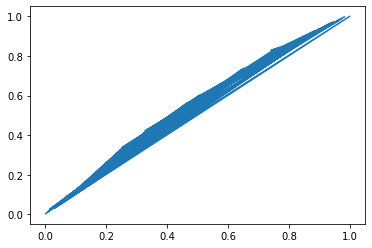

In [17]:
# and plot our ROC curve!
import matplotlib.pyplot as plt

# plot the false positive rate by true postive rate (aka recall)
plt.plot(roc.false_positive_rate, roc.recall)

#### predicción de nuevos datos

si quiero predecir nuevos datos tengo que volver a aplicar las mismas transformaciones que realicé en el dataset de entrenamiento

In [20]:
%%bigquery

# Predict
SELECT
  *
FROM
  ML.PREDICT(MODEL `proyecto.nps.bigquery_ml_wei_logistic_reg`,
    (SELECT FARM_FINGERPRINT(CONCAT(CAST(tecnologia AS STRING), wtod_score_modem_min, CAST(modem AS STRING))) as row_fingerprint,
    rand() as random, modem, tecnologia,
  wtod_score_modem_avg, wtod_score_modem_stddev, wtod_score_modem_min,  wtod_score_modem_max,
    wbhp_score_modem_avg, wbhp_score_modem_stddev,  wbhp_score_modem_min,  wbhp_score_modem_max,
    wts_score_modem_avg, wts_score_modem_stddev, wts_score_modem_min, wts_score_modem_max,
    wdr_score_modem_avg, wdr_score_modem_stddev,  wdr_score_modem_min,  wdr_score_modem_max,
    wpl_score_modem_avg, wpl_score_modem_stddev, wpl_score_modem_min, wpl_score_modem_max,
    wi_score_modem_avg, wi_score_modem_stddev,  wi_score_modem_min,  wi_score_modem_max,
    wlbu_score_modem_avg, wlbu_score_modem_stddev, wlbu_score_modem_min, wlbu_score_modem_max, 
     ML.FEATURE_CROSS(STRUCT(modem, tecnologia)) AS modem_tecnologia,
     ML.POLYNOMIAL_EXPAND(STRUCT(wi_score_modem_avg), 3) as wi_score_polinomio, ##creates x, x2, x3, etc.
     ML.BUCKETIZE(wi_score_modem_max, [20, 40, 60, 80]) as wi_score_bucket, ## where split_points is an array   ##SI AGREGO ALGUNA VARIABLE LA DEBO METER ACA TAMBIEN 
     FROM `proyecto.nps.qualtrics_wei_train_data` limit 1000));


Downloading: 100%|██████████| 1000/1000 [00:01<00:00, 927.50rows/s]


,trial_id,predicted_nps,predicted_nps_probs,row_fingerprint,random,modem,tecnologia,wtod_score_modem_avg,wtod_score_modem_stddev,wtod_score_modem_min,...,wi_score_modem_stddev,wi_score_modem_min,wi_score_modem_max,wlbu_score_modem_avg,wlbu_score_modem_stddev,wlbu_score_modem_min,wlbu_score_modem_max,modem_tecnologia,wi_score_polinomio,wi_score_bucket
0,5,1,"[{'label': 1, 'prob': 0.5119489387966467}, {'l...",4484183361832963093,0.698354,tchn4233,HFC,0.0,0.0,0.0,...,0.168925,27.491830,27.959677,79.778571,4.145915,72.14,84.68,{'modem_tecnologia': 'tchn4233_HFC'},"{'wi_score_modem_avg': 27.764320706951597, 'wi...",bin_2
1,5,1,"[{'label': 1, 'prob': 0.5258830232852112}, {'l...",4484183361832963093,0.785056,tchn4233,HFC,0.0,0.0,0.0,...,0.520072,38.220211,39.619131,47.265714,3.960231,42.25,53.24,{'modem_tecnologia': 'tchn4233_HFC'},"{'wi_score_modem_avg': 39.006959633703374, 'wi...",bin_2
2,5,1,"[{'label': 1, 'prob': 0.5733736804602553}, {'l...",-5339490955989020034,0.747859,smbs3686,HFC,0.0,0.0,0.0,...,0.526675,15.722222,17.187500,67.265714,20.251103,49.39,100.00,{'modem_tecnologia': 'smbs3686_HFC'},"{'wi_score_modem_avg': 16.039497163140958, 'wi...",bin_1
3,5,1,"[{'label': 1, 'prob': 0.5399272386107161}, {'l...",6085560282673740129,0.684044,smbs3890,HFC,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,38.987143,2.064895,36.68,41.52,{'modem_tecnologia': 'smbs3890_HFC'},"{'wi_score_modem_avg': 0.0, 'wi_score_modem_av...",bin_1
4,5,1,"[{'label': 1, 'prob': 0.5154103396537411}, {'l...",6085560282673740129,0.373204,smbs3890,HFC,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,100.000000,0.000000,100.00,100.00,{'modem_tecnologia': 'smbs3890_HFC'},"{'wi_score_modem_avg': 0.0, 'wi_score_modem_av...",bin_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5,1,"[{'label': 1, 'prob': 0.5255756989836936}, {'l...",4349173671011907940,0.478708,tchn3848,HFC,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,81.500000,2.032838,79.44,85.86,{'modem_tecnologia': 'tchn3848_HFC'},"{'wi_score_modem_avg': 0.0, 'wi_score_modem_av...",bin_1
996,5,1,"[{'label': 1, 'prob': 0.5459918385033293}, {'l...",4484183361832963093,0.340037,tchn4233,HFC,0.0,0.0,0.0,...,0.461074,25.837766,26.997951,52.623333,5.478907,44.62,58.36,{'modem_tecnologia': 'tchn4233_HFC'},"{'wi_score_modem_avg': 26.36731926251088, 'wi_...",bin_2
997,5,1,"[{'label': 1, 'prob': 0.5394972158700791}, {'l...",4484183361832963093,0.827906,tchn4233,HFC,0.0,0.0,0.0,...,0.717361,27.321429,29.013158,94.290000,0.838868,93.03,95.53,{'modem_tecnologia': 'tchn4233_HFC'},"{'wi_score_modem_avg': 27.968981480000352, 'wi...",bin_2
998,5,1,"[{'label': 1, 'prob': 0.5414637174807879}, {'l...",4484183361832963093,0.804194,tchn4233,HFC,0.0,0.0,0.0,...,0.022352,36.560284,36.617575,70.995714,0.852347,69.49,71.82,{'modem_tecnologia': 'tchn4233_HFC'},"{'wi_score_modem_avg': 36.59559349709018, 'wi_...",bin_2


#### Explicar el modelo a nivel fila

Con este tipo de explicación puede entender que variable resulta relevante en cada caso

In [12]:
%%bigquery

#Explain Predictions
SELECT
  *
FROM
  ML.EXPLAIN_PREDICT(MODEL `proyecto.nps.bigquery_ml_wei_logistic_reg`,
    (SELECT *, ML.FEATURE_CROSS(STRUCT(modem, tecnologia)) AS modem_tecnologia,
    ML.POLYNOMIAL_EXPAND(STRUCT(wi_score_modem_avg), 3) as wi_score_polinomio, ##creates x, x2, x3, etc.
     ML.BUCKETIZE(wi_score_modem_max, [20, 40, 60, 80]) as wi_score_bucket, ## where split_points is an array   ##SI AGREGO ALGUNA VARIABLE LA DEBO METER ACA TAMBIEN 
     FROM `proyecto.nps.qualtrics_wei_train_data` limit 1000),
    STRUCT(3 as top_k_features));

Downloading: 100%|██████████| 1000/1000 [00:00<00:00, 1141.26rows/s]


,trial_id,predicted_nps,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,dt,contrato,IdSubscripcion,...,wi_score_modem_max,wi_score_modem_min,wi_score_modem_stddev,wlbu_score_modem_avg,wlbu_score_modem_max,wlbu_score_modem_min,wlbu_score_modem_stddev,modem_tecnologia,wi_score_polinomio,wi_score_bucket
0,4,1,0.518783,"[{'feature': 'wi_score_bucket', 'attribution':...",0.046751,0.075168,0.0,2022-10-09,51098446,51098446,...,22.678571,22.290419,0.188791,78.235000,79.22,77.49,0.782155,{'modem_tecnologia': 'alcl240j_FTTH'},"{'wi_score_modem_avg': 22.4614860001252, 'wi_s...",bin_2
1,4,1,0.572695,"[{'feature': 'wts_score_modem_stddev', 'attrib...",0.046751,0.292856,0.0,2022-10-09,91182892,91182892,...,0.000000,0.000000,0.000000,100.000000,100.00,100.00,0.000000,{'modem_tecnologia': 'smbs3890_HFC'},"{'wi_score_modem_avg': 0.0, 'wi_score_modem_av...",bin_1
2,4,1,0.519147,"[{'feature': 'wi_score_bucket', 'attribution':...",0.046751,0.076626,0.0,2022-10-09,51364667,51364667,...,0.000000,0.000000,0.000000,100.000000,100.00,100.00,0.000000,{'modem_tecnologia': 'smbs3890_HFC'},"{'wi_score_modem_avg': 0.0, 'wi_score_modem_av...",bin_1
3,4,1,0.523456,"[{'feature': 'wi_score_bucket', 'attribution':...",0.046751,0.093893,0.0,2022-10-09,12702392,12702392,...,0.000000,0.000000,0.000000,96.597500,96.68,96.49,0.079320,{'modem_tecnologia': 'smbs3890_HFC'},"{'wi_score_modem_avg': 0.0, 'wi_score_modem_av...",bin_1
4,4,1,0.563658,[{'feature': 'modem_tecnologia_modem_tecnologi...,0.046751,0.256023,0.0,2022-10-09,12935330,12935330,...,0.000000,0.000000,0.000000,85.855000,88.71,82.91,3.169695,{'modem_tecnologia': 'tchn3848_HFC'},"{'wi_score_modem_avg': 0.0, 'wi_score_modem_av...",bin_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,1,0.572292,"[{'feature': 'wi_score_bucket', 'attribution':...",0.046751,0.291208,0.0,2022-10-05,13416344,13416344,...,41.546003,39.478205,0.751216,80.242857,85.98,73.88,4.522218,{'modem_tecnologia': 'tchn4233_HFC'},"{'wi_score_modem_avg': 40.47681851886534, 'wi_...",bin_3
996,4,1,0.553124,[{'feature': 'modem_tecnologia_modem_tecnologi...,0.046751,0.213302,0.0,2022-10-05,30618899,30618899,...,0.000000,0.000000,0.000000,65.018571,66.92,63.07,1.488550,{'modem_tecnologia': 'tean4439_FTTH'},"{'wi_score_modem_avg': 0.0, 'wi_score_modem_av...",bin_1
997,4,1,0.527730,"[{'feature': 'wi_score_bucket', 'attribution':...",0.046751,0.111034,0.0,2022-10-05,60185151,60185151,...,16.056548,15.729167,0.133753,30.182857,32.29,27.92,1.463520,{'modem_tecnologia': 'alcl2425g_FTTH'},"{'wi_score_modem_avg': 15.908970836855458, 'wi...",bin_1
998,4,1,0.514452,"[{'feature': 'wi_score_bucket', 'attribution':...",0.046751,0.057825,0.0,2022-10-05,64402368,64402368,...,17.661290,17.018072,0.241037,60.572857,65.47,58.81,2.280985,{'modem_tecnologia': 'alcl2425g_FTTH'},"{'wi_score_modem_avg': 17.441736563131528, 'wi...",bin_1


#### Explicar globales del modelo

Con este tipo de explicación puede entender que variable resulta relevante para el total del dataset. Para esto tengo que volver a correr el modelo ya que debo tildar la opcion enable_global_explain

In [22]:
%%bigquery

##Para que esto funciona hay que indicarle al modelo que define las explicaciones globales - una vez que tenes el mejor modelo se puede aplicar

# Creating the baseline model
CREATE OR REPLACE MODEL
  `proyecto.nps.bigquery_ml_wei_logistic_reg`
    OPTIONS (model_type='logistic_reg', input_label_cols=['nps'],
   num_trials=10, ##HIPERPARAMETRO
   max_parallel_trials=2, ##HIPERPARAMETRO
   l1_reg=hparam_range(0, 2), ##HIPERPARAMETRO
   l2_reg=hparam_candidates([0, 0.1, 1, 10]), ##HIPERPARAMETRO
            enable_global_explain=TRUE ##GLOBAL EXPLANATIONS
            ) AS
SELECT
    wtod_score_modem_avg, wtod_score_modem_stddev, wtod_score_modem_min,  wtod_score_modem_max,
    wbhp_score_modem_avg, wbhp_score_modem_stddev,  wbhp_score_modem_min,  wbhp_score_modem_max,
    wts_score_modem_avg, wts_score_modem_stddev, wts_score_modem_min, wts_score_modem_max,
    wdr_score_modem_avg, wdr_score_modem_stddev,  wdr_score_modem_min,  wdr_score_modem_max,
    wpl_score_modem_avg, wpl_score_modem_stddev, wpl_score_modem_min, wpl_score_modem_max,
    wi_score_modem_avg, wi_score_modem_stddev,  wi_score_modem_min,  wi_score_modem_max,
    wlbu_score_modem_avg, wlbu_score_modem_stddev, wlbu_score_modem_min, wlbu_score_modem_max, 
    ML.FEATURE_CROSS(STRUCT(modem, tecnologia)) AS modem_tecnologia, ## le indico dos variables y me calcula las combinaciones
    ML.POLYNOMIAL_EXPAND(STRUCT(wi_score_modem_avg), 3) as wi_score_polinomio, ##creates x, x2, x3, etc.
    ML.BUCKETIZE(wi_score_modem_max, [20, 40, 60, 80]) as wi_score_bucket, ## where split_points is an array
   nps 
FROM
  `proyecto.nps.qualtrics_wei_train_data`

Query complete after 0.00s: 100%|██████████| 21/21 [00:00<00:00, 11715.93query/s]                      


""


Identifico la importancia de variables

In [31]:
%%bigquery
SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL `proyecto.nps.bigquery_ml_wei_logistic_reg`, STRUCT(TRUE AS class_level_explain))

Downloading: 100%|██████████| 20/20 [00:00<00:00, 24.65rows/s]


,trial_id,nps,feature,attribution
0,3,0,modem_tecnologia_modem_tecnologia,0.115793
1,3,0,wi_score_bucket,0.050000
2,3,0,wbhp_score_modem_min,0.013731
3,3,0,wbhp_score_modem_max,0.013311
4,3,0,wbhp_score_modem_avg,0.012967
5,3,0,wlbu_score_modem_min,0.010049
6,3,0,wi_score_modem_min,0.008740
7,3,0,wlbu_score_modem_stddev,0.008621
8,3,0,wi_score_modem_avg,0.007592
9,3,0,wi_score_polinomio_wi_score_modem_avg,0.007592
